**Homework 22**

We begin as in Homework 21 by importing a set of face images:

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
faces=lfw_people.images

To assist with model building, it helps to clip the dimesnions of each image to numbers easily divisible by 2, and add a channel:

In [20]:
faces=faces[:,:48,:36] #clip each image to 48 x 36
faces=faces.reshape((1288,48,36,1)) #add a channel

The purpose of this assignment is to build a neural network to remove noise from images. You'll test your network on an image of George W. Bush:

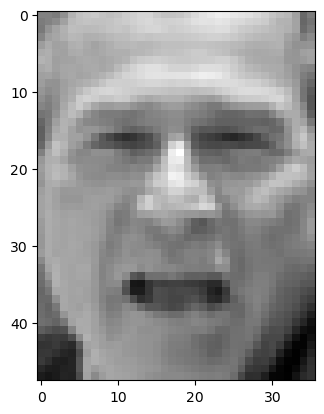

In [21]:
bush=faces[10]
plt.imshow(bush,cmap='gray')

Your goal will be to restore this image from one in which noise has been introduced:

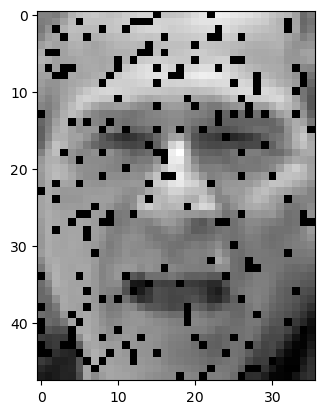

In [22]:
noisyface=(np.random.choice([0]+9*[1],48*36).reshape(48,36,1))*bush
plt.imshow(noisyface,cmap='gray')

We load the necessary model building imports from PyTorch.

In [23]:
import torch
import torch.nn as nn
from torch.optim import Adam

The first step is to convert our data to the correct type:

In [24]:
faces=torch.tensor(faces).float().reshape(-1,1,48,36)

Now, build encoder, decoder, and autoencoder models. I've started this for you with a dropout layer in the encoder, which turns some pixels "off". This simulates noise in the image during training. During inference (i.e. when you use the trained model to remove noise form an image) don't forget to call model.eval() to turn off the Dropout layer. When we train this we'll use the same image for both feature and target, producing a model that takes in noisy images and produces "clean" ones.

Each image in the `faces` dataset is already normalized so the pixel values are between 0 and 1. Make sure the final layer of your decoder outputs only numbers between 0 and 1 (hint: what function did we learn in class that has outputs betwen 0 and 1?)

In [25]:
encoder=nn.Sequential(
    nn.Dropout(0.1),
    nn.Conv2d(1, 16, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(16, 64, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 128, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(3)
)

decoder=nn.Sequential(
    nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=3, padding=0),
    nn.ConvTranspose2d(in_channels=64, out_channels=16, kernel_size=2, stride=2, padding=0),
    nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2, padding=0),
    nn.Sigmoid()
)

autoencoder=nn.Sequential(encoder,decoder)

Define an Adam optimizer for this model with an initial learning rate of 0.001.

In [26]:
optimizer= Adam(autoencoder.parameters(), lr=0.001)

Define a training loop to fit your model. Periodically report your loss.

In [27]:
n_epochs=1000
N = faces.shape[0]  # total number of observations in training data
batch_size=100

for epoch in range(n_epochs):
  # Shuffle the indices
  indices = torch.randperm(N)

  # Create mini-batches
  for i in range(0, N, batch_size):
    batch_indices = indices[i:i+batch_size]
    batch_X = faces[batch_indices]
    batch_y = faces[batch_indices]

    optimizer.zero_grad()
    MSEloss = nn.MSELoss()(autoencoder(batch_X), batch_y)
    MSEloss.backward()
    optimizer.step()

  if epoch%100==0:
    print(f"epoch: {epoch}, loss: {MSEloss.item()}")

epoch: 0, loss: 0.025240909308195114
epoch: 100, loss: 0.00433745700865984
epoch: 200, loss: 0.0035670818760991096
epoch: 300, loss: 0.0030214085709303617
epoch: 400, loss: 0.00307147903367877
epoch: 500, loss: 0.0028846708592027426
epoch: 600, loss: 0.0026960589457303286
epoch: 700, loss: 0.0023670962546020746
epoch: 800, loss: 0.0024864429142326117
epoch: 900, loss: 0.002156777074560523


If your model works correctly, this code should remove the noise in the noisyface image:

In [31]:
noisyface=torch.tensor(noisyface).float().reshape(1,1,48,36)

autoencoder.eval()
denoisedface=autoencoder(noisyface)

C:\Users\teren\AppData\Local\Temp\ipykernel_14304\793903556.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisyface=torch.tensor(noisyface).float().reshape(1,1,48,36)


Let's look at it! You're image should be slightly blurrier than the original image, but all the black pixels should be restored.

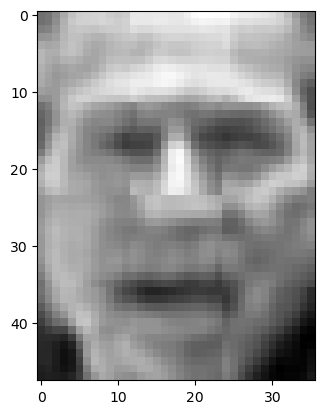

In [32]:
plt.imshow(denoisedface.detach().numpy().reshape(48,36),cmap='gray')

Take a screen shot of your denoised image, and upload that to gradescope. (You'll have to upload as a pdf. Contact me for help with file conversion, if you need it.)